In [4]:
import os
import pandas as pd
import numpy as np
import math
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt  #畫圖形
import statsmodels.api as sm   #statsmodels用於估計許多不同統計模型的類和函數
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf  # acf和pacf展示庫
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA  # 導入ARIMA模型

In [2]:
def sort_data(Data):
    d = Data["Date"]
    d = pd.to_datetime(d)

    data = Data["Price"]
    data.index = pd.Index(d)

    return data

def missing_value():
    SAT = pd.date_range(start = '01/01/2016', end = '03/31/2019', freq='W-SAT')

    SUN = pd.date_range(start = '01/01/2016', end = '05/31/2018', freq='W-SUN')

    s1 = pd.Series([np.nan]*len(SAT) ,index=SAT)
    s2 = pd.Series([np.nan]*len(SUN) ,index=SUN)
    
    return s1, s2
    
def supplement_data(data):
    s1, s2 = missing_value()
    
    data = data.append(s1)
    data = data.append(s2)
    
    data.sort_index(inplace=True)
    
    for j in range(len(data)):
        null_value = data[data.isnull().values == True]
        if len(null_value) != 0:
            for i in range(len(null_value)):
                if math.isnan(data[null_value.index[i]+timedelta(-1)]) == False:
                    if math.isnan(data[null_value.index[i]+timedelta(1)]) == False: 
                        data[null_value.index[i]] = (data[null_value.index[i]+timedelta(-1)]+data[null_value.index[i]+timedelta(1)])/2
            data = data.fillna(method = 'ffill', limit = 1)
            data = data.fillna(method = 'bfill', limit = 1)            
        else:
            break
            
    return data

def split(data):
    train = data[:'2019-01-01']    
    true = data['2019-01-01':]
    last = pd.Series(train['2018-12-31'], index=['2018-12-31'])
    
    return train, true, last

def ADF(train):
    t=sm.tsa.stattools.adfuller(train)  #ADF檢驗
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]  #滯後階數
    output['value']['Number of Observations Used'] = t[3]  #ADF回歸和計算臨界值所使用的觀察次數
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']

    return output

def model(x, order):
    model =ARIMA(x, order=order)  # ARIMA的參數: order = p, d, q
    results_ARIMA =model.fit(disp=-1,method = 'mle')
    predict_data = results_ARIMA.predict(start='2019-01-01', end='2019-03-31', dynamic = False) 
    
    return predict_data

def predict(last, predict_data):
    predicted_data = last.append(predict_data).cumsum()
    predicted_data = predicted_data[1:]
    
    return predicted_data   
    
def plot_data(true_data, predicted_data):
    plt.figure(figsize=(12,6))
    plt.plot(predicted_data.index, true_data, color = 'cornflowerblue', marker = 'o', label='True')
    plt.plot(predicted_data.index, predicted_data, color = 'lightcoral', marker = 'o', label='Predict')
    plt.legend()
    plt.show()

In [3]:
Data = pd.read_excel("c:/python/AUD-USD/AUD_USD.xlsx",index_col=False)
data = sort_data(Data)
data = supplement_data(data)
train, true, last = split(data)

In [47]:
ADF(train)

,value
Test Statistic Value,-2.16694
p-value,0.218461
Lags Used,0
Number of Observations Used,1096
Critical Value(1%),-3.43633
Critical Value(5%),-2.86418
Critical Value(10%),-2.56818


In [48]:
train_diff = train.diff(1).dropna()
ADF(train_diff)

,value
Test Statistic Value,-34.3046
p-value,0
Lags Used,0
Number of Observations Used,1095
Critical Value(1%),-3.43634
Critical Value(5%),-2.86418
Critical Value(10%),-2.56818


In [49]:
order = st.arma_order_select_ic(train,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])

C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\joyl

C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse 

In [50]:
print('aic')
print(order['aic'])
print('aic_min_order:',order['aic_min_order'])
print('--------------------------------------------------------------------')
print('bic')
print(order['bic'])
print('bic_min_order:',order['bic_min_order'])

aic
             0            1            2            3            4  \
0 -4967.217673 -6247.489279 -7125.505585 -7653.456238 -8016.251080   
1 -9165.039077 -9164.116229 -9162.402994 -9160.417880 -9159.046352   
2 -9164.151320 -9162.858597 -9160.967453 -9158.968931 -9156.987797   
3 -9162.424547 -9160.822376 -9159.174724 -9157.491181 -9155.594868   
4 -9160.440616 -9158.968345 -9157.483849 -9158.380115 -9159.742625   
5 -9159.055605 -9157.392192 -9155.575677 -9157.673537 -9153.066376   

             5  
0 -8225.898099  
1 -9157.228716  
2 -9155.306839  
3 -9153.563124  
4 -9158.019810  
5 -9150.998054  
aic_min_order: (1, 0)
--------------------------------------------------------------------
bic
             0            1            2            3            4  \
0 -4957.217004 -6232.488275 -7105.504247 -7628.454565 -7986.249074   
1 -9150.038073 -9144.114891 -9137.401322 -9130.415873 -9124.044011   
2 -9144.149982 -9137.856925 -9130.965447 -9123.966590 -9116.985121   
3 -9137.422

In [5]:
predict_data = model(train, (1,1,0))
start = time.time()
predicted_data = predict(last, predict_data)
end = time.time()
running_time = end-start
print(running_time)

0.0014882087707519531


C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [52]:
RMSE = np.sqrt(((predicted_data-true)**2).sum()/true.size)
MAPE = abs((true-predicted_data)/true).sum()/len(true)

In [53]:
RMSE

0.010267818502686472

In [54]:
MAPE

0.012425530518492139

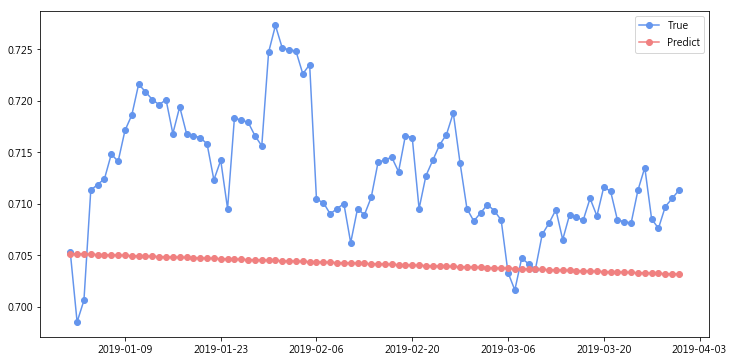

In [55]:
plot_data(true , predicted_data)